# Week 4

### How to Deal with Experimantal Spectrum which may contain Errors?

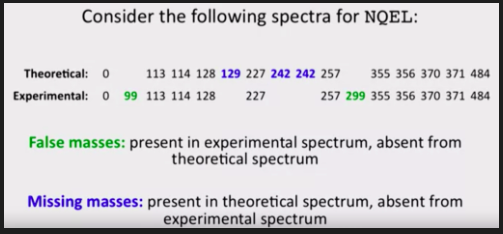

In [3]:
with open('/Users/olegsuchalko/BioinformaticsAlgorithms/II.GenomeSequencing/Week_3-4/integer_mass_table.txt') as mass_file:
    mass_dict = {
        line.split()[0]: int(line.split()[-1]) for line in mass_file.readlines()
    }

print(mass_dict)

with open('/Users/olegsuchalko/BioinformaticsAlgorithms/II.GenomeSequencing/Week_3-4/integer_mass_table.txt') as mass_file:
    reversed_mass_dict_simplified = { # здесь мы не отличаем аминокислоты с одинаковыми массами
        int(line.split()[-1]): line.split()[0] for line in mass_file.readlines()
    }

print(reversed_mass_dict_simplified)

{'G': 57, 'A': 71, 'S': 87, 'P': 97, 'V': 99, 'T': 101, 'C': 103, 'I': 113, 'L': 113, 'N': 114, 'D': 115, 'K': 128, 'Q': 128, 'E': 129, 'M': 131, 'H': 137, 'F': 147, 'R': 156, 'Y': 163, 'W': 186}
{57: 'G', 71: 'A', 87: 'S', 97: 'P', 99: 'V', 101: 'T', 103: 'C', 113: 'L', 114: 'N', 115: 'D', 128: 'Q', 129: 'E', 131: 'M', 137: 'H', 147: 'F', 156: 'R', 163: 'Y', 186: 'W'}


### Functions from Week 3

In [296]:
def CountMass(Peptide):
    return sum([ mass_dict[aminoacid] for aminoacid in Peptide ])


def SubpeptidesLinear(Peptide:str):
    return sorted([ Peptide[i:i+j] for i in range(len(Peptide)) for j in range(1, len(Peptide)-i+1) ], key=len)


def SubpeptidesCyclic(Peptide:str):
    cycle = Peptide + Peptide
    return [ cycle[i:i+j] for j in range(1, len(Peptide)) for i in range(len(Peptide)) ] + [ Peptide ]


def MassSpectrum(Peptides:list, mode="C"):
    massSpec = [ CountMass(fragment) for  fragment in Peptides ]
    massSpec.insert(0, 0)
    return sorted(massSpec)

In [297]:
MassSpectrum(Peptides=SubpeptidesCyclic("NQEL"), )

[0, 113, 114, 128, 129, 227, 242, 242, 257, 355, 356, 370, 371, 484]

In [298]:
MassSpectrum(Peptides=SubpeptidesLinear("NQEL"))

[0, 113, 114, 128, 129, 242, 242, 257, 370, 371, 484]

### LeaderboardCyclopeptideSequencing.

First we need to define Score as number of mathces between Theoretical and Experimental Spectra for Peptide

#### Score Function

In [525]:
from collections import Counter


def ScorePeptide(Peptide, Spectrum:list, structure="A", mode="L"):
    '''
    Function to count Score of similarity between theoratical and experimental spectra. 
    It sums minimal frequencies of masses, which exist in both dictionaries.
    Can work with Linear and Cyclic versions ($mode).
    Can work with both Peptides constructed from Aminoacids or Masses ($structure).
    '''
    ExperimentalFreqDict = Counter(Spectrum)
    if structure in ["A", "Aminoacid", "a", "aminoacid"]: # для записи в виде аминокислот, например NQE
        if mode in ["C", "Cyclic"]:
            TheoreticalFreqDict = Counter(MassSpectrum(Peptides=SubpeptidesCyclic(Peptide=Peptide)))
        elif mode in ["L", "Linear"]:
            TheoreticalFreqDict = Counter(MassSpectrum(Peptides=SubpeptidesLinear(Peptide=Peptide)))

    elif structure in ["M", "Mass", "m", "mass"]: # для записи в виде масс, например 113-97-114
        if type(Peptide) == str:
            Peptide = Peptide.split('-')

        if mode == "C":
            TheoreticalFreqDict = Counter([ sum([int(i) for i in item]) for item in SubpeptidesCyclic(Peptide) ])
        elif mode == "L":
            TheoreticalFreqDict = Counter([ sum([int(i) for i in item]) for item in SubpeptidesLinear(Peptide) ])
    
    # выводим сумму минимальных частот по обоим словарям: в теор спектре 114 встречается 2 раза, а в экспериментальном 1 раз, запишем 1
    Score = sum([ 
        min(TheoreticalFreqDict[mass], ExperimentalFreqDict[mass])
        for mass in TheoreticalFreqDict if mass in ExperimentalFreqDict
    ])
    if 0 in Spectrum:
        Score += 1
    return Score


In [526]:
ScorePeptide(
    Peptide="114-128-129-113",     
    Spectrum=[0, 99, 113, 114, 128, 227, 257, 299, 355, 356, 370, 371, 484], mode="L", structure="m"
    # Spectrum=[int(i) for i in input().split()], mode="L"
)

8

We now can redefine the Cyclopeptide Sequencing Problem for noisy spectra:

#### Cyclopeptide Sequencing Problem (for spectra with errors): 
Find a cyclic peptide having maximum score against an experimental spectrum.

Input: A collection of integers Spectrum.

Output: A cyclic peptide Peptide maximizing Score(Peptide, Spectrum) over all peptides Peptide with mass equal to ParentMass(Spectrum).


In [527]:
from collections import Counter


def ExpandPeptides(Peptides, Spectrum, mode, structure):
    '''
    Function to expand Peptide with 1 aminoacid and keep it
    '''
    return {  # делаем словарь, в котором имеющиеся пептиды дополняются на одну аминокислоту, считаются их масса и score
        (str(peptide) + '-' + str(aminoacid)): {
            "mass": Peptides[peptide]["mass"] + int(aminoacid),
            "components": Peptides[peptide]["components"] + [aminoacid],
            "score": ScorePeptide(
                Peptide=Peptides[peptide]["components"]+[aminoacid], Spectrum=Spectrum, mode=mode, structure=structure)
        } for peptide in Peptides for aminoacid in reversed_mass_dict_simplified } # здесь добавляем по каждой из АМК


def TrimPeptidesByScore(Peptides:dict, N:int):
    '''
    Function to extract Peptides with top-N scores
    '''
    if len(Peptides) > N: # если надо тримить, определяем топ-N score
        scoresToKeep = set(sorted([ Peptides[key]["score"] for key in Peptides ], reverse=True)[:N])
        return {
            peptide: {
                "score": Peptides[peptide]["score"], 
                "mass": Peptides[peptide]["mass"],
                "components": Peptides[peptide]["components"]
            } for peptide in Peptides if Peptides[peptide]["score"] in scoresToKeep # отбираем только образцы, у которых score входит в топ-N
        }
    else: return Peptides # если набор пептидов меньше N, то оставляем всех

In [532]:
import math


def LeaderboardCyclopeptideSequencing(Spectrum:list, N:int):
    '''
    Function to Combine aminoacids in all possible positions one by one step by step, keep N best results by Score on each Step 
    until we find best solution LeaderPeptide with mass equal to maxMass among Spectrum.
    '''
    LeaderPeptide = []
    LeaderScore = 0
    LeaderBoard = { str(aminoacid): { # создаем словарь пептидов длинной в одну АМК, считаем их массы и Score
        "score": ScorePeptide(Peptide=str(aminoacid), Spectrum=Spectrum, mode="L", structure="M"),
        "mass": aminoacid,
        "components": [aminoacid]
     } for aminoacid in reversed_mass_dict_simplified }
    LeaderBoard
    LeaderBoard = TrimPeptidesByScore(LeaderBoard, N) # оставляем N лучших score (и равные)

    while LeaderBoard:
        N = math.ceil(N)
        # сокращаем N каждую итерацию - не обязательно, но сильно ускоряет
        # чем дальше, тем точнее мы идем (на ранних стадиях есть риск пропустить нужный пептид)
        for peptide in LeaderBoard:

            if LeaderBoard[peptide]["mass"] == max(Spectrum): # если масса пептида максимальная
                cyclicScore = ScorePeptide(peptide, Spectrum, structure="M", mode="C")
                if  cyclicScore > LeaderScore: # проверяем его  CyclicScore
                    print(cyclicScore, peptide)
                    LeaderPeptide = [peptide]
                    LeaderScore = cyclicScore
                elif cyclicScore == LeaderScore:
                    LeaderPeptide.append(peptide)

            elif LeaderBoard[peptide]["mass"] > max(Spectrum): # если масса пептида превышает максимальную в спектре, выкидываем
                LeaderBoard = { key:LeaderBoard[key] for key in LeaderBoard if key != peptide }

        LeaderBoard = ExpandPeptides(LeaderBoard, Spectrum, mode="L", structure="M")
        LeaderBoard = TrimPeptidesByScore(LeaderBoard, N)

    return LeaderPeptide , LeaderScore

In [529]:
LeaderboardCyclopeptideSequencing(
    Spectrum=[0, 71, 113, 129, 147, 200, 218, 260, 313, 331, 347, 389, 460], N=10
)

13 71-129-113-147


(['71-129-113-147',
  '71-147-113-129',
  '113-129-71-147',
  '113-147-71-129',
  '129-71-147-113',
  '129-113-147-71',
  '147-71-129-113',
  '147-113-129-71'],
 13,
 8,
 8)

Better speed with decreasing N

We point out that because a linear peptide giving rise to the highest-scoring cyclic peptide may be trimmed from the leaderboard early on, LeaderboardCyclopeptideSequencing is a heuristic, not guaranteed to correctly solve the Cyclopeptide Sequencing Problem.

Applying LeaderboardCyclopeptideSequencing to spectrum with error rate 10% (with N = 1000) results in the correct cyclic peptide **VKLFPWFNQY**, which has a score of 86.

So far, LeaderboardCyclopeptideSequencing has worked well, but as the number of errors increases, so does the likelihood that this algorithm will return an incorrect peptide. Let’s see how this algorithm performs on a noisier simulated spectrum of Tyrocidine B1, which has 25% missing/false masses.

In [549]:
reversed_mass_dict_simplified

{57: 'G',
 71: 'A',
 87: 'S',
 97: 'P',
 99: 'V',
 101: 'T',
 103: 'C',
 113: 'L',
 114: 'N',
 115: 'D',
 128: 'Q',
 129: 'E',
 131: 'M',
 137: 'H',
 147: 'F',
 156: 'R',
 163: 'Y',
 186: 'W'}

In [523]:
Spectrum10 = [int(i) for i in input().split()]

In [513]:
Spectrum25 = [int(i) for i in input().split()]

In [552]:
ScorePeptide(Peptide='97-147-113-128-99-163-71-57-57-57-147-71-115'.split('-'), Spectrum=Spectrum25, structure='m', mode="C")

83

In [541]:
x = list()
for i in range(1):
    x1, score_x1 = LeaderboardCyclopeptideSequencing(
        Spectrum=Spectrum25, N=3200
    )
    print(score_x1, len(x1))
    x += x1

65 71-156-163-128-114-147-186-97-147-113
70 97-113-128-99-163-128-114-147-186-147
71 97-147-113-128-99-163-114-128-147-186
82 97-147-113-128-99-163-128-114-147-186
83 71-115-147-114-128-163-99-128-113-147-97
83 44


In [542]:
len(set(x))

44

In [548]:
peptides = list()
for i in x:
    pept = ''.join([reversed_mass_dict_simplified[int(j)] for j in i.split('-')])
    peptides.append((pept[pept.index('V'):]+ pept[:pept.index('V')]))

print(peptides)
print(set(peptides))

['VQLFPADFNQY', 'VQLFPADFNQY', 'VQLFPDAFNQY', 'VYQNFADPFLQ', 'VYQNFDAPFLQ', 'VYQNFADPFLQ', 'VYQNFDAPFLQ', 'VYQNFADPFLQ', 'VYQNFDAPFLQ', 'VQLFPADFNQY', 'VQLFPDAFNQY', 'VYQNFDAPFLQ', 'VQLFPDAFNQY', 'VQLFPADFNQY', 'VYQNFADPFLQ', 'VYQNFDAPFLQ', 'VYQNFADPFLQ', 'VYQNFDAPFLQ', 'VQLFPADFNQY', 'VQLFPADFNQY', 'VYQNFADPFLQ', 'VYQNFDAPFLQ', 'VQLFPADFNQY', 'VQLFPDAFNQY', 'VQLFPADFNQY', 'VQLFPDAFNQY', 'VYQNFADPFLQ', 'VYQNFDAPFLQ', 'VQLFPADFGGQY', 'VYGANFDAPFLQ', 'VYAGNFDAPFLQ', 'VYQGGFADPFLQ', 'VYQGGFDAPFLQ', 'VQLFPADFGGQY', 'VQLFPDAFGGQY', 'VYQGGFADPFLQ', 'VYQGGFDAPFLQ', 'VQLFPADFNGAY', 'VQLFPDAFNGAY', 'VQLFPADFNAGY', 'VQLFPDAFNAGY', 'VGALFPADFNQY', 'VAGLFPADFNQY', 'VAGLFPDAFNQY']
{'VQLFPDAFNQY', 'VYQGGFDAPFLQ', 'VYQNFADPFLQ', 'VQLFPDAFNGAY', 'VAGLFPDAFNQY', 'VQLFPADFNQY', 'VYGANFDAPFLQ', 'VQLFPADFGGQY', 'VQLFPADFNGAY', 'VQLFPDAFNAGY', 'VQLFPADFNAGY', 'VQLFPDAFGGQY', 'VYAGNFDAPFLQ', 'VYQGGFADPFLQ', 'VGALFPADFNQY', 'VAGLFPADFNQY', 'VYQNFDAPFLQ'}


In [522]:
''.join([reversed_mass_dict_simplified[int(i)] for i in '71-115-147-114-128-163-99-128-113-147-97'.split('-')])

'ADFNQYVQLFP'

In [ ]:
VQLFPADFNQY

In [472]:
'113-128-99-163-128-114-147-186-97-147'.split('-')

['113', '128', '99', '163', '128', '114', '147', '186', '97', '147']

['113', '147', '71', '129 71', '147', '129', '113']